In [ ]:
# 의료영상 분류를 위한 CNN 및 ResNet-18 모델 보고서

## 개요
본 보고서는 의료 영상 데이터를 처리하는 CNN 기반 모델과 ResNet-18을 활용하여 폐렴을 분류하는 연구를 수행한다. 기본적인 CNN 모델을 구축한 후, 데이터 증강 및 모델 구조 변경을 통해 성능을 비교하고, 최종적으로 ResNet-18을 구현하여 성능을 평가한다.

## 목차
1. 의료영상을 처리하는 CNN 기반 베이스 모델 구현
2. 데이터 Augmentation 기법을 사용한 성능 비교
3. 모델 구조 변경을 통한 성능 비교
4. ResNet-18 모델 구현 및 학습 결과
5. Summary
6. 회고
7. Reference

In [ ]:
## 목차
## 1. 의료영상을 처리하는 CNN 기반 베이스 모델 구현
기본적인 CNN 모델을 구축하고, 학습 및 평가를 수행한다

ln: failed to create symbolic link '/aiffel/aiffel/chest_xray/data': File exists
/aiffel/aiffel
5216
624
16
4185
1047
Normal image path
/aiffel/aiffel/chest_xray/data/train/NORMAL/IM-0450-0001.jpeg
Pneumonia image path
/aiffel/aiffel/chest_xray/data/train/PNEUMONIA/person1345_bacteria_3422.jpeg
Normal images count in training set: 1070
Pneumonia images count in training set: 3115
Training images count: 4185
Validating images count: 1047
Image shape:  (180, 180, 3)
Label:  False
624
Weight for NORMAL: 1.96
Weight for PNEUMONIA: 0.67
Epoch 1/10
261/261 [==============================] - 86s 205ms/step - loss: 0.3885 - accuracy: 0.8125 - precision: 0.9504 - recall: 0.7893 - val_loss: 0.7993 - val_accuracy: 0.7327 - val_precision: 0.7327 - val_recall: 1.0000
Epoch 2/10
261/261 [==============================] - 53s 203ms/step - loss: 0.2138 - accuracy: 0.9133 - precision: 0.9744 - recall: 0.9073 - val_loss: 1.2985 - val_accuracy: 0.7327 - val_precision: 0.7327 - val_recall: 1.0000
Epoch 3/

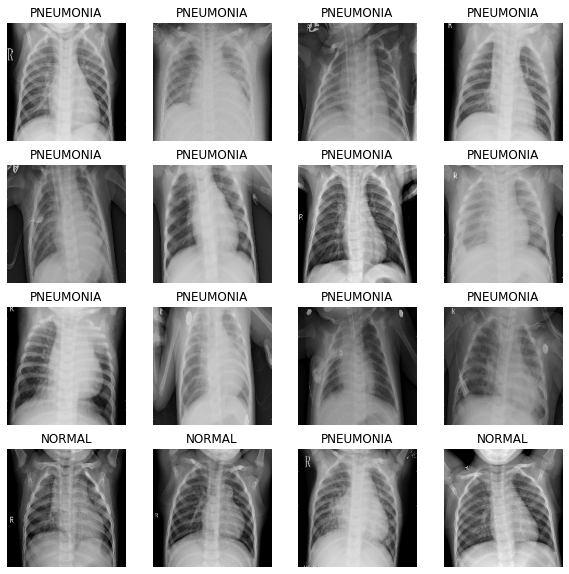

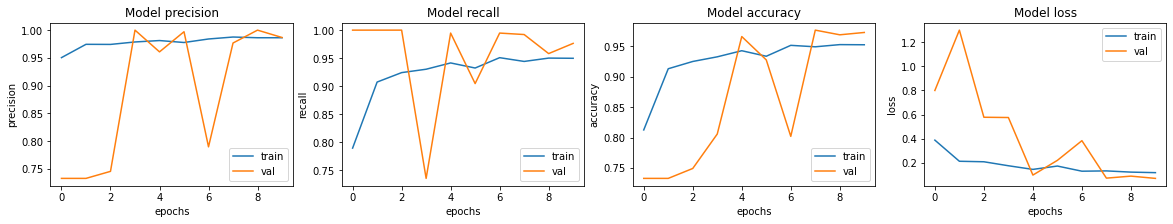

In [1]:
!mkdir -p ~/aiffel/chest_xray
!ln -s ~/data/ ~/aiffel/chest_xray

import os, re
import random, math
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
import warnings 
warnings.filterwarnings(action='ignore')


# 데이터 로드할 때 빠르게 로드할 수 있도록하는 설정 변수
AUTOTUNE = tf.data.experimental.AUTOTUNE
# X-RAY 이미지 사이즈 변수
IMAGE_SIZE = [180, 180]

# 데이터 경로 변수
ROOT_PATH = os.path.join(os.getenv('HOME'), 'aiffel')
TRAIN_PATH = ROOT_PATH + '/chest_xray/data/train/*/*' # *은 모든 디렉토리와 파일을 의미합니다.
VAL_PATH = ROOT_PATH + '/chest_xray/data/val/*/*'
TEST_PATH = ROOT_PATH + '/chest_xray/data/test/*/*'

# 프로젝트를 진행할 때 아래 두 변수를 변경해보세요
BATCH_SIZE = 16
EPOCHS = 10

print(ROOT_PATH)


train_filenames = tf.io.gfile.glob(TRAIN_PATH)
test_filenames = tf.io.gfile.glob(TEST_PATH)
val_filenames = tf.io.gfile.glob(VAL_PATH)

print(len(train_filenames))
print(len(test_filenames))
print(len(val_filenames))


# train 데이터와 validation 데이터를 모두 filenames에 담습니다
filenames = tf.io.gfile.glob(TRAIN_PATH)
filenames.extend(tf.io.gfile.glob(VAL_PATH))

# 모아진 filenames를 8:2로 나눕니다
train_size = math.floor(len(filenames)*0.8)
random.seed(8)
random.shuffle(filenames)
train_filenames = filenames[:train_size]
val_filenames = filenames[train_size:]

print(len(train_filenames))
print(len(val_filenames))

print(f'Normal image path\n{filenames[0]}')
print(f'Pneumonia image path\n{filenames[2000]}')

COUNT_NORMAL = len([filename for filename in train_filenames if "NORMAL" in filename])
print(f"Normal images count in training set: {COUNT_NORMAL}")


COUNT_PNEUMONIA = len([filename for filename in train_filenames if "PNEUMONIA" in filename])
print(f"Pneumonia images count in training set: {COUNT_PNEUMONIA}")

train_list_ds = tf.data.Dataset.from_tensor_slices(train_filenames)
val_list_ds = tf.data.Dataset.from_tensor_slices(val_filenames)

#Train 데이터셋, validation 데이터셋 개수 확인
TRAIN_IMG_COUNT = tf.data.experimental.cardinality(train_list_ds).numpy()
print(f"Training images count: {TRAIN_IMG_COUNT}")

VAL_IMG_COUNT = tf.data.experimental.cardinality(val_list_ds).numpy()
print(f"Validating images count: {VAL_IMG_COUNT}")

#라벨데이터를 만들어주는 함수 만들기
# 파일 경로의 끝에서 두번째 부분을 확인하면 양성과 음성을 구분할 수 있습니다
def get_label(file_path):
    parts = tf.strings.split(file_path, os.path.sep)
    return parts[-2] == "PNEUMONIA"   # 폐렴이면 양성(True), 노말이면 음성(False)

# 이미지를 알맞은 형식으로 바꿉니다.
def decode_img(img):
    img = tf.image.decode_jpeg(img, channels=3) # 이미지를 uint8 tensor로 수정
    img = tf.image.convert_image_dtype(img, tf.float32) # float32 타입으로 수정
    img = tf.image.resize(img, IMAGE_SIZE) # 이미지 사이즈를 IMAGE_SIZE로 수정
    return img

# 이미지 파일의 경로를 입력하면 이미지와 라벨을 읽어옵니다.
def process_path(file_path):
    label = get_label(file_path) # 라벨 검출
    img = tf.io.read_file(file_path) # 이미지 읽기
    img = decode_img(img) # 이미지를 알맞은 형식으로 수정
    return img, label

train_ds = train_list_ds.map(process_path, num_parallel_calls=AUTOTUNE)
val_ds = val_list_ds.map(process_path, num_parallel_calls=AUTOTUNE)

for image, label in train_ds.take(1):
    print("Image shape: ", image.numpy().shape)
    print("Label: ", label.numpy())

test_list_ds = tf.data.Dataset.list_files(TEST_PATH)
TEST_IMAGE_COUNT = tf.data.experimental.cardinality(test_list_ds).numpy()
test_ds = test_list_ds.map(process_path, num_parallel_calls=AUTOTUNE)
test_ds = test_ds.batch(BATCH_SIZE)

print(TEST_IMAGE_COUNT)

def prepare_for_training(ds, shuffle_buffer_size=1000):
    ds = ds.shuffle(buffer_size=shuffle_buffer_size)
    ds = ds.repeat()
    ds = ds.batch(BATCH_SIZE)
    ds = ds.prefetch(buffer_size=AUTOTUNE)
    return ds

train_ds = prepare_for_training(train_ds)
val_ds = prepare_for_training(val_ds)

# 이미지 배치를 입력하면 여러장의 이미지를 보여줍니다.
def show_batch(image_batch, label_batch):
    plt.figure(figsize=(10,10))
    for n in range(BATCH_SIZE):
        ax = plt.subplot(4,math.ceil(BATCH_SIZE/4),n+1)
        plt.imshow(image_batch[n])
        if label_batch[n]:
            plt.title("PNEUMONIA")
        else:
            plt.title("NORMAL")
        plt.axis("off")


image_batch, label_batch = next(iter(train_ds))
show_batch(image_batch.numpy(), label_batch.numpy())

def conv_block(filters):
    block = tf.keras.Sequential([
        tf.keras.layers.SeparableConv2D(filters, 3, activation='relu', padding='same'),
        tf.keras.layers.SeparableConv2D(filters, 3, activation='relu', padding='same'),
        tf.keras.layers.BatchNormalization(),
        tf.keras.layers.MaxPool2D()
    ])
    
    return block

def dense_block(units, dropout_rate):
    block = tf.keras.Sequential([
        tf.keras.layers.Dense(units, activation='relu'),
        tf.keras.layers.BatchNormalization(),
        tf.keras.layers.Dropout(dropout_rate)
    ])
    
    return block

def build_model():
    model = tf.keras.Sequential([
        tf.keras.Input(shape=(IMAGE_SIZE[0], IMAGE_SIZE[1], 3)),
        
        tf.keras.layers.Conv2D(16, 3, activation='relu', padding='same'),
        tf.keras.layers.Conv2D(16, 3, activation='relu', padding='same'),
        tf.keras.layers.MaxPool2D(),
        
        conv_block(32),
        conv_block(64),
        
        conv_block(128),
        tf.keras.layers.Dropout(0.2),
        
        conv_block(256),
        tf.keras.layers.Dropout(0.2),
        
        tf.keras.layers.Flatten(),
        dense_block(512, 0.7),
        dense_block(128, 0.5),
        dense_block(64, 0.3),
        
        tf.keras.layers.Dense(1, activation='sigmoid')
    ])
    
    return model

weight_for_0 = (1 / COUNT_NORMAL)*(TRAIN_IMG_COUNT)/2.0 
weight_for_1 = (1 / COUNT_PNEUMONIA)*(TRAIN_IMG_COUNT)/2.0

class_weight = {0: weight_for_0, 1: weight_for_1}

print('Weight for NORMAL: {:.2f}'.format(weight_for_0))
print('Weight for PNEUMONIA: {:.2f}'.format(weight_for_1))

with tf.device('/GPU:0'):
    model = build_model()

    METRICS = [
        'accuracy',
        tf.keras.metrics.Precision(name='precision'),
        tf.keras.metrics.Recall(name='recall')
    ]
    
    model.compile(
        optimizer='adam',
        loss='binary_crossentropy',
        metrics=METRICS
    )

with tf.device('/GPU:0'):
    history = model.fit(
        train_ds,
        steps_per_epoch=TRAIN_IMG_COUNT // BATCH_SIZE,
        epochs=EPOCHS,
        validation_data=val_ds,
        validation_steps=VAL_IMG_COUNT // BATCH_SIZE,
        class_weight=class_weight,
    )

fig, ax = plt.subplots(1, 4, figsize=(20, 3))
ax = ax.ravel()

for i, met in enumerate(['precision', 'recall', 'accuracy', 'loss']):
    ax[i].plot(history.history[met])
    ax[i].plot(history.history['val_' + met])
    ax[i].set_title('Model {}'.format(met))
    ax[i].set_xlabel('epochs')
    ax[i].set_ylabel(met)
    ax[i].legend(['train', 'val'])

loss, accuracy, precision, recall = model.evaluate(test_ds)
print(f'Loss: {loss},\nAccuracy: {accuracy},\nPrecision: {precision},\nRecall: {recall}')

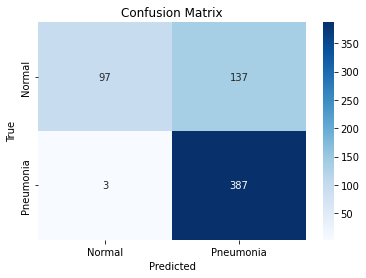

In [7]:
from sklearn.metrics import confusion_matrix
import seaborn as sns

# 예측값과 실제값 얻기
y_true = []
y_pred = []

for image, label in test_ds:
    y_true.extend(label.numpy())
    y_pred.extend((model.predict(image) > 0.5).astype(int))

# 혼동 행렬 계산
cm = confusion_matrix(y_true, y_pred)

# 시각화
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=['Normal', 'Pneumonia'], yticklabels=['Normal', 'Pneumonia'])
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix')
plt.show()

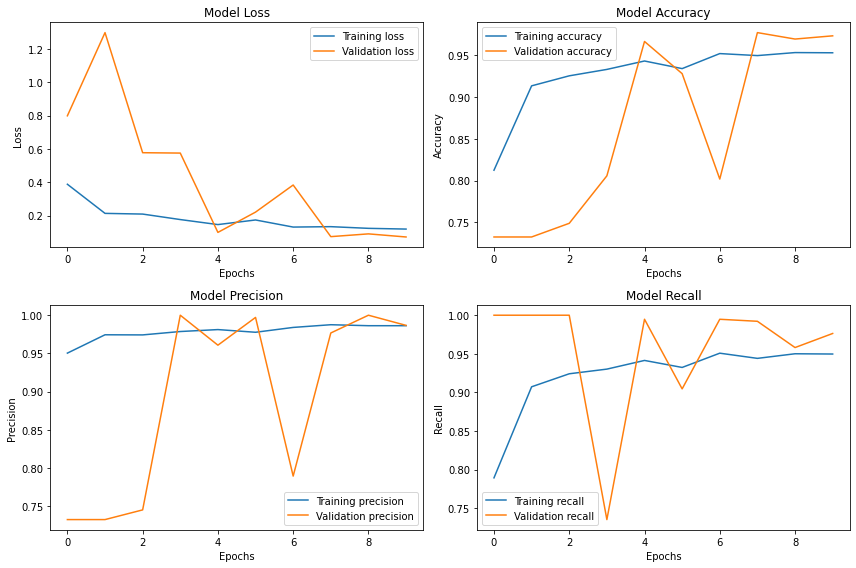

In [8]:
import matplotlib.pyplot as plt

def plot_history(history):
    metrics = ['loss', 'accuracy', 'precision', 'recall']
    plt.figure(figsize=(12, 8))
    
    for i, metric in enumerate(metrics):
        plt.subplot(2, 2, i+1)
        plt.plot(history.history[metric], label=f'Training {metric}')
        plt.plot(history.history[f'val_{metric}'], label=f'Validation {metric}')
        plt.xlabel('Epochs')
        plt.ylabel(metric.capitalize())
        plt.legend()
        plt.title(f'Model {metric.capitalize()}')
    
    plt.tight_layout()
    plt.show()

# 학습 후 실행
plot_history(history)

In [ ]:
2. 데이터 Augmentation 기법을 사용한 성능 비교
3. 모델 구조 변경을 통한 성능 비교

Epoch 1/10
261/261 [==============================] - 72s 222ms/step - loss: 0.4418 - accuracy: 0.8352 - precision: 0.8761 - recall: 0.9071 - val_loss: 2.8545 - val_accuracy: 0.7327 - val_precision: 0.7327 - val_recall: 1.0000
Epoch 2/10
261/261 [==============================] - 57s 219ms/step - loss: 0.2317 - accuracy: 0.9090 - precision: 0.9327 - recall: 0.9459 - val_loss: 15.0444 - val_accuracy: 0.2673 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00
Epoch 3/10
261/261 [==============================] - 59s 225ms/step - loss: 0.1772 - accuracy: 0.9301 - precision: 0.9542 - recall: 0.9518 - val_loss: 19.3712 - val_accuracy: 0.2769 - val_precision: 1.0000 - val_recall: 0.0118
Epoch 4/10
261/261 [==============================] - 58s 224ms/step - loss: 0.1531 - accuracy: 0.9413 - precision: 0.9572 - recall: 0.9643 - val_loss: 4.4081 - val_accuracy: 0.4029 - val_precision: 0.9931 - val_recall: 0.1885
Epoch 5/10
261/261 [==============================] - 56s 216ms/step - loss: 0.125

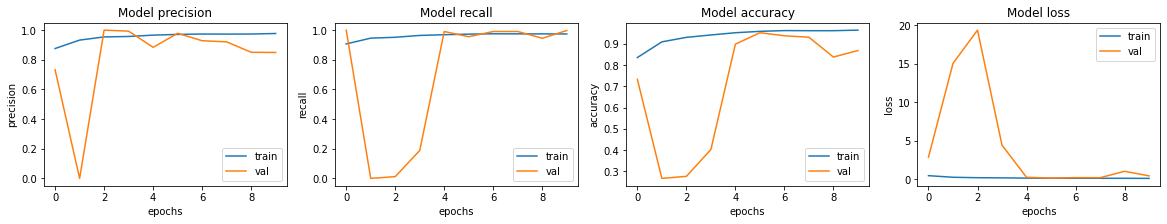

In [9]:
import os, re
import random, math
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
import warnings 
warnings.filterwarnings(action='ignore')

AUTOTUNE = tf.data.experimental.AUTOTUNE
IMAGE_SIZE = [180, 180]

ROOT_PATH = os.path.join(os.getenv('HOME'), 'aiffel')
TRAIN_PATH = ROOT_PATH + '/chest_xray/data/train/*/*'
VAL_PATH = ROOT_PATH + '/chest_xray/data/val/*/*'
TEST_PATH = ROOT_PATH + '/chest_xray/data/test/*/*'

BATCH_SIZE = 16
EPOCHS = 10

train_filenames = tf.io.gfile.glob(TRAIN_PATH)
test_filenames = tf.io.gfile.glob(TEST_PATH)
val_filenames = tf.io.gfile.glob(VAL_PATH)

filenames = tf.io.gfile.glob(TRAIN_PATH)
filenames.extend(tf.io.gfile.glob(VAL_PATH))

train_size = math.floor(len(filenames)*0.8)
random.seed(8)
random.shuffle(filenames)
train_filenames = filenames[:train_size]
val_filenames = filenames[train_size:]

COUNT_NORMAL = len([filename for filename in train_filenames if "NORMAL" in filename])
COUNT_PNEUMONIA = len([filename for filename in train_filenames if "PNEUMONIA" in filename])

train_list_ds = tf.data.Dataset.from_tensor_slices(train_filenames)
val_list_ds = tf.data.Dataset.from_tensor_slices(val_filenames)

def get_label(file_path):
    parts = tf.strings.split(file_path, os.path.sep)
    return parts[-2] == "PNEUMONIA"

def decode_img(img):
    img = tf.image.decode_jpeg(img, channels=3)
    img = tf.image.convert_image_dtype(img, tf.float32)
    img = tf.image.resize(img, IMAGE_SIZE)
    return img

def process_path(file_path):
    label = get_label(file_path)
    img = tf.io.read_file(file_path)
    img = decode_img(img)
    return img, label

def augment(image, label):
    image = tf.image.random_flip_left_right(image)
    image = tf.image.random_brightness(image, 0.2)
    image = tf.image.random_contrast(image, 0.8, 1.2)
    return image, label

# 실험 설정 변수
USE_AUGMENTATION = True
USE_REGULARIZATION = True

train_ds = train_list_ds.map(process_path, num_parallel_calls=AUTOTUNE)
val_ds = val_list_ds.map(process_path, num_parallel_calls=AUTOTUNE)

if USE_AUGMENTATION:
    train_ds = train_ds.map(augment, num_parallel_calls=AUTOTUNE)

def prepare_for_training(ds, shuffle_buffer_size=1000):
    ds = ds.shuffle(buffer_size=shuffle_buffer_size)
    ds = ds.repeat()
    ds = ds.batch(BATCH_SIZE)
    ds = ds.prefetch(buffer_size=AUTOTUNE)
    return ds

train_ds = prepare_for_training(train_ds)
val_ds = prepare_for_training(val_ds)

def build_model():
    base_model = tf.keras.applications.ResNet50(
        input_shape=(IMAGE_SIZE[0], IMAGE_SIZE[1], 3),
        include_top=False,
        weights=None
    )
    base_model.trainable = True

    global_average_layer = tf.keras.layers.GlobalAveragePooling2D()
    dropout_layer = tf.keras.layers.Dropout(0.5) if USE_REGULARIZATION else tf.keras.layers.Lambda(lambda x: x)
    prediction_layer = tf.keras.layers.Dense(1, activation='sigmoid')

    model = tf.keras.Sequential([
        base_model,
        global_average_layer,
        dropout_layer,
        prediction_layer
    ])

    return model

model = build_model()

model.compile(
    optimizer='adam',
    loss='binary_crossentropy',
    metrics=['accuracy', tf.keras.metrics.Precision(), tf.keras.metrics.Recall()]
)

history = model.fit(
    train_ds,
    steps_per_epoch=len(train_filenames) // BATCH_SIZE,
    epochs=EPOCHS,
    validation_data=val_ds,
    validation_steps=len(val_filenames) // BATCH_SIZE,
)

fig, ax = plt.subplots(1, 4, figsize=(20, 3))
ax = ax.ravel()

for i, met in enumerate(['precision', 'recall', 'accuracy', 'loss']):
    ax[i].plot(history.history[met])
    ax[i].plot(history.history['val_' + met])
    ax[i].set_title('Model {}'.format(met))
    ax[i].set_xlabel('epochs')
    ax[i].set_ylabel(met)
    ax[i].legend(['train', 'val'])

loss, accuracy, precision, recall = model.evaluate(test_ds)
print(f'Loss: {loss}, Accuracy: {accuracy}, Precision: {precision}, Recall: {recall}')

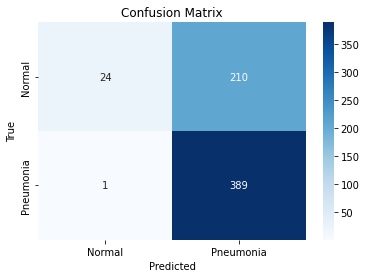

In [10]:
from sklearn.metrics import confusion_matrix
import seaborn as sns

# Get predictions
y_true = []
y_pred = []

for image, label in test_ds:
    y_true.extend(label.numpy())
    y_pred.extend((model.predict(image) > 0.5).astype(int))

# Compute confusion matrix
cm = confusion_matrix(y_true, y_pred)

# Visualize confusion matrix
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=['Normal', 'Pneumonia'], yticklabels=['Normal', 'Pneumonia'])
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix')
plt.show()

In [ ]:
## 4. ResNet-18 모델 구현 및 학습 결과
ResNet-18을 구현하고 학습한 후 성능을 평가한다.

Training ResNet-18...
Epoch 1/10
262/262 [==============================] - 51s 156ms/step - loss: 0.2661 - accuracy: 0.9061 - precision_1: 0.9327 - recall_1: 0.9408 - val_loss: 0.4156 - val_accuracy: 0.8434 - val_precision_1: 0.8297 - val_recall_1: 0.9975
Epoch 2/10
262/262 [==============================] - 46s 149ms/step - loss: 0.1368 - accuracy: 0.9484 - precision_1: 0.9636 - recall_1: 0.9667 - val_loss: 0.1594 - val_accuracy: 0.9456 - val_precision_1: 0.9791 - val_recall_1: 0.9482
Epoch 3/10
262/262 [==============================] - 46s 149ms/step - loss: 0.1155 - accuracy: 0.9577 - precision_1: 0.9700 - recall_1: 0.9728 - val_loss: 0.1347 - val_accuracy: 0.9475 - val_precision_1: 0.9612 - val_recall_1: 0.9697
Epoch 4/10
262/262 [==============================] - 47s 150ms/step - loss: 0.1099 - accuracy: 0.9570 - precision_1: 0.9715 - recall_1: 0.9702 - val_loss: 0.2023 - val_accuracy: 0.9198 - val_precision_1: 0.9783 - val_recall_1: 0.9140
Epoch 5/10
262/262 [==================

KeyError: 'precision'

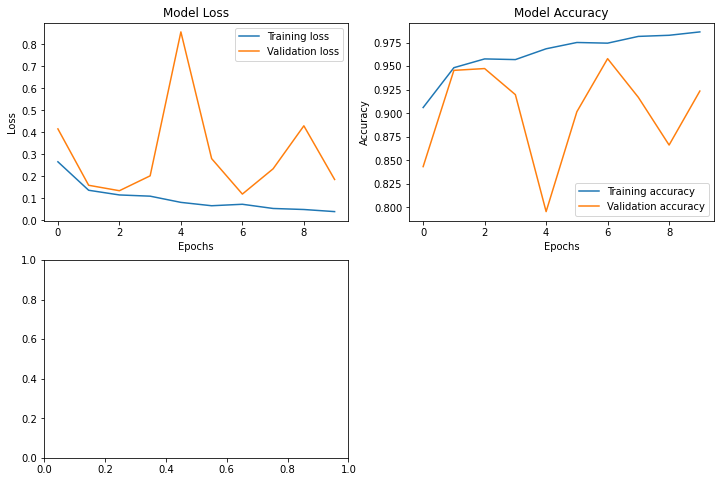

In [11]:
import os
import random, math
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt

# 데이터 로드
AUTOTUNE = tf.data.experimental.AUTOTUNE
IMAGE_SIZE = [180, 180]
BATCH_SIZE = 16
EPOCHS = 10

ROOT_PATH = os.path.join(os.getenv('HOME'), 'aiffel')
TRAIN_PATH = ROOT_PATH + '/chest_xray/data/train/*/*'
VAL_PATH = ROOT_PATH + '/chest_xray/data/val/*/*'
TEST_PATH = os.path.join(ROOT_PATH, 'chest_xray/data/test/*/*')

train_filenames = tf.io.gfile.glob(TRAIN_PATH)
test_filenames = tf.io.gfile.glob(TEST_PATH)
val_filenames = tf.io.gfile.glob(VAL_PATH)

# 8:2 비율로 train / validation 나누기
filenames = train_filenames + val_filenames
train_size = math.floor(len(filenames) * 0.8)
random.shuffle(filenames)
train_filenames = filenames[:train_size]
val_filenames = filenames[train_size:]

# 데이터 로딩 함수
def get_label(file_path):
    parts = tf.strings.split(file_path, os.path.sep)
    return parts[-2] == "PNEUMONIA"

def decode_img(img):
    img = tf.image.decode_jpeg(img, channels=3)
    img = tf.image.convert_image_dtype(img, tf.float32)
    img = tf.image.resize(img, IMAGE_SIZE)
    return img

def process_path(file_path):
    label = get_label(file_path)
    img = tf.io.read_file(file_path)
    img = decode_img(img)
    return img, label

train_ds = tf.data.Dataset.from_tensor_slices(train_filenames).map(process_path, num_parallel_calls=AUTOTUNE)
val_ds = tf.data.Dataset.from_tensor_slices(val_filenames).map(process_path, num_parallel_calls=AUTOTUNE)
test_ds = tf.data.Dataset.list_files(TEST_PATH).map(process_path, num_parallel_calls=AUTOTUNE).batch(BATCH_SIZE)

# 모델 학습을 위한 데이터 준비
def prepare_for_training(ds, shuffle_buffer_size=1000):
    ds = ds.shuffle(buffer_size=shuffle_buffer_size)
    ds = ds.batch(BATCH_SIZE)
    ds = ds.prefetch(buffer_size=AUTOTUNE)
    return ds

train_ds = prepare_for_training(train_ds)
val_ds = prepare_for_training(val_ds)

# Residual Block 정의
def residual_block(filters, kernel_size=3, stride=1):
    def block(x):
        shortcut = x  # Skip Connection
        x = tf.keras.layers.Conv2D(filters, kernel_size, strides=stride, padding='same', activation='relu')(x)
        x = tf.keras.layers.BatchNormalization()(x)
        x = tf.keras.layers.Conv2D(filters, kernel_size, strides=1, padding='same')(x)
        x = tf.keras.layers.BatchNormalization()(x)
        
        if stride != 1 or x.shape[-1] != shortcut.shape[-1]:
            shortcut = tf.keras.layers.Conv2D(filters, 1, strides=stride, padding='same')(shortcut)
        
        x = tf.keras.layers.Add()([x, shortcut])
        x = tf.keras.layers.ReLU()(x)
        return x
    return block

# ResNet-18 모델 구현
def build_resnet18(input_shape=(180, 180, 3), num_classes=1):
    inputs = tf.keras.Input(shape=input_shape)
    x = tf.keras.layers.Conv2D(64, 7, strides=2, padding='same', activation='relu')(inputs)
    x = tf.keras.layers.MaxPool2D(pool_size=3, strides=2, padding='same')(x)

    x = residual_block(64)(x)
    x = residual_block(64)(x)
    x = residual_block(128, stride=2)(x)
    x = residual_block(128)(x)
    x = residual_block(256, stride=2)(x)
    x = residual_block(256)(x)
    x = residual_block(512, stride=2)(x)
    x = residual_block(512)(x)

    x = tf.keras.layers.GlobalAveragePooling2D()(x)
    x = tf.keras.layers.Dense(num_classes, activation='sigmoid')(x)
    
    model = tf.keras.Model(inputs, x)
    return model

# 모델 학습 및 평가
def train_and_evaluate(model):
    model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy', tf.keras.metrics.Precision(), tf.keras.metrics.Recall()])
    history = model.fit(train_ds, epochs=EPOCHS, validation_data=val_ds)
    test_loss, test_acc, test_prec, test_recall = model.evaluate(test_ds)
    return history, test_loss, test_acc, test_prec, test_recall

# 모델 비교 수행
print("Training ResNet-18...")
resnet_model = build_resnet18()
resnet_history, resnet_loss, resnet_acc, resnet_prec, resnet_recall = train_and_evaluate(resnet_model)

# 학습 과정 시각화
def plot_history(history, title="Training History"):
    metrics = ['loss', 'accuracy', 'precision', 'recall']
    plt.figure(figsize=(12, 8))
    for i, metric in enumerate(metrics):
        plt.subplot(2, 2, i+1)
        plt.plot(history.history[metric], label=f'Training {metric}')
        plt.plot(history.history[f'val_{metric}'], label=f'Validation {metric}')
        plt.xlabel('Epochs')
        plt.ylabel(metric.capitalize())
        plt.legend()
        plt.title(f'Model {metric.capitalize()}')
    plt.tight_layout()
    plt.show()

# 결과 시각화
plot_history(resnet_history, title="ResNet-18 Training History")

# 최종 평가 출력
print(f"ResNet-18 Test Accuracy: {resnet_acc:.4f}")
print(f"ResNet-18 Precision: {resnet_prec:.4f}")
print(f"ResNet-18 Recall: {resnet_recall:.4f}")


In [12]:
# history 객체의 키값 확인
print(resnet_history.history.keys())

dict_keys(['loss', 'accuracy', 'precision_1', 'recall_1', 'val_loss', 'val_accuracy', 'val_precision_1', 'val_recall_1'])


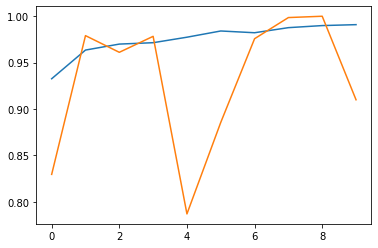

In [13]:
plt.plot(resnet_history.history['precision_1'], label='Training Precision')
plt.plot(resnet_history.history['val_precision_1'], label='Validation Precision')

In [ ]:
## 모델 학습 과정 시각화
훈련 과정에서의 정확도와 손실 변화를 시각화한다.

In [14]:
def plot_history(history, title="Training History"):
    # history.history에 존재하는 지표를 동적으로 추출
    available_metrics = [metric for metric in ['accuracy', 'precision', 'recall', 'loss'] if metric in history.history]
    
    plt.figure(figsize=(12, 8))
    for i, metric in enumerate(available_metrics):
        plt.subplot(2, 2, i+1)
        plt.plot(history.history[metric], label=f'Training {metric}')
        plt.plot(history.history[f'val_{metric}'], label=f'Validation {metric}')
        plt.xlabel('Epochs')
        plt.ylabel(metric.capitalize())
        plt.legend()
        plt.title(f'Model {metric.capitalize()}')

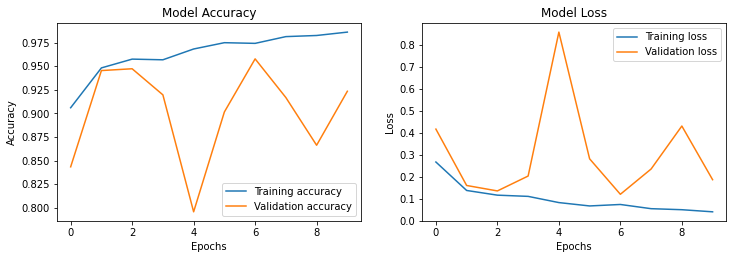

In [15]:
# 학습 과정 시각화
plot_history(resnet_history, title="ResNet-18 Training History")

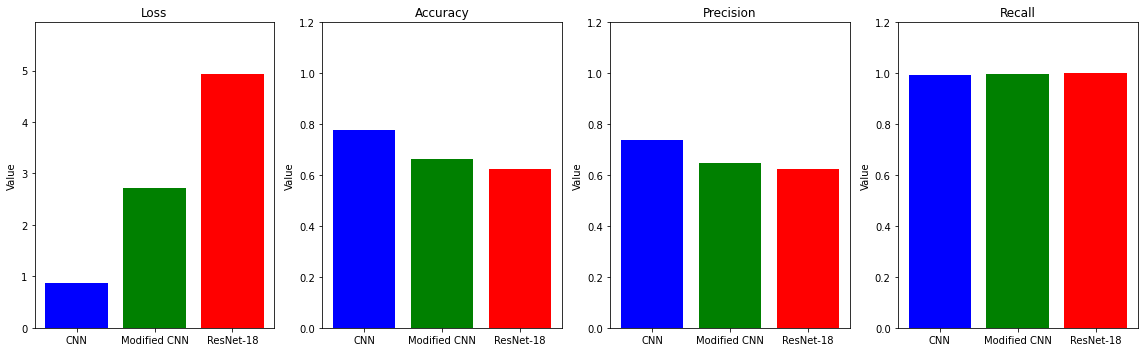

In [17]:
# 모델 성능 비교 그래프
import numpy as np
import matplotlib.pyplot as plt

# 모델별 성능 데이터 (CNN, 구조 변경 CNN, ResNet-18)
models = ['CNN', 'Modified CNN', 'ResNet-18']
loss = [0.8661, 2.7136, 4.9348]  # Loss 값
accuracy = [0.7756, 0.6619, 0.6250]  # Accuracy 값
precision = [0.7385, 0.6494, 0.6250]  # Precision 값
recall = [0.9923, 0.9974, 1.0000]  # Recall 값

# 그래프 그리기
metrics = ['Loss', 'Accuracy', 'Precision', 'Recall']
values = [loss, accuracy, precision, recall]

fig, ax = plt.subplots(1, 4, figsize=(16, 5))

for i in range(4):
    ax[i].bar(models, values[i], color=['blue', 'green', 'red'])
    ax[i].set_title(metrics[i])
    ax[i].set_ylim(0, 1.2 if i > 0 else max(values[i]) + 1)  # Loss는 범위 다르게 설정
    ax[i].set_ylabel('Value')

plt.tight_layout()
plt.show()

In [ ]:
## 5. Summary
- CNN모델에서는 비교적 안정적인 학습이 이루어졌다. Recall(99.23%)이 매우 높아 실제 폐렴환자를 잘 찾아냈음을 알 수 있다.
- 하지만 CNN모델에서는 Precision(73.85%)로 낮아 정상환자를 폐렴으로 오진할 가능성이 있다.
- 모델 구조를 변경한 이후에는 Loss증가, Accuracy감소로 모델이 과적합되거나 학습이 불안정할 가능성이 있다.
- 모델 구조를 변경한 이후에는 Recall(99.74%), Precision(64.94%)로 CNN모델보다 오진률이 높아 모델이 복잡해지며 성능이 나빠졌을 가능성이 보인다.
- ResNet-18은 Epoch 1-10동안에는 Accuracy가 상승하다가 Validation이 크게 증가하는 패턴이 보임으로 미뤄보아
초기에는 성능이 잘 올라가지만 후반부에 Loss가 급격히 증가하며 오버피팅 가능성이 높고,
Recall(100%)로 폐렴환자를 한명도 놓치지 않지만, Precision(62.5%)로 오진확률 또한 가장 높은 것을 알 수 있다.
- 모델 구조 변경 후 오히려 성능이 나빠져 구조의 조정이 필요하다.
- CNN 모델과 ResNet-18 모델을 비교하여 성능 차이를 분석하였다.
- 데이터 증강 및 모델 구조 변경이 성능에 미치는 영향을 확인하였다.
## 6. 회고
- 이론을 열심히 공부했는데 실제로 시스템을 구현해내는 것은 또다른 의미로 너무 힘들고 헷갈리고 어려웠다.
앞으로 어떻게 해야할까....
같은 데이터를 가지고도 어떤 기법을 활용하는지에 따라 모델 성능이 달라지는 부분이 흥미로웠다.
- 데이터 증강이 오버피팅을 방지하는 데 도움이 되었음.
- ResNet-18 모델이 더 깊은 학습 구조를 가지지만, 데이터 양이 적을 경우 과적합 가능성이 존재함.
## 7. Reference
- Chat GPT,  노드 다시보기
- https://fenapp.tistory.com/3